In [1]:
import functools
import itertools
import logging
import math
import os
import pickle
import sys
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sns
import yaml

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_context("poster")
sns.set(rc={"figure.figsize": (16, 12.0)})
sns.set_style("whitegrid")

import numpy as np
import pandas as pd
import torch.nn.functional as F

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [2]:
from lda4rec.datasets import Interactions, DataLoader, random_train_test_split, items_per_user_train_test_split
from lda4rec.evaluations import summary
from lda4rec.estimators import MFEst, PopEst, LDA4RecEst, SNMFEst
from lda4rec.utils import process_ids, cmp_ranks, reparam_beta
from lda4rec import lda

In [3]:
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import torch
from pyro.distributions import constraints
from pyro.infer import SVI, Predictive, Trace_ELBO, TraceEnum_ELBO, config_enumerate

In [4]:
import neptune.new as neptune
# init dummy neptune to avoid problems with logging
neptune.init(mode='offline') 

offline/02550c0e-553a-46cb-8acc-fe1082c908fe
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [5]:
from icecream import ic, install

install()
# configure icecream
def ic_str(obj):
    if hasattr(obj, "shape"):
        return f"{obj} "  #
    else:
        return str(obj)

In [6]:
ic.configureOutput(argToStringFunction=ic_str)

## Experimenting with different estimators

In [34]:
loader = DataLoader()
data = loader.load_movielens("100k")

In [35]:
max_interactions = 200
data.max_user_interactions_(max_interactions, rng=42)

In [36]:
data.implicit_(0.)
train, test = items_per_user_train_test_split(data, n_items_per_user=10, rng=42)

In [37]:
data.n_items

9724

In [10]:
pop_est = PopEst()
pop_est.fit(train)

In [11]:
summary(pop_est, train=train, test=test)

,train,test
metric,,
prec,0.289836,0.101149
recall,0.054435,0.069478
mrr,0.515369,0.291043


In [12]:
mf_est = MFEst(embedding_dim=4, n_iter=30)
mf_est.fit(train)

INFO:lda4rec.estimators:Epoch     0: loss 0.4121378366206143
INFO:lda4rec.estimators:Epoch     1: loss 0.23928146152882962
INFO:lda4rec.estimators:Epoch     2: loss 0.14850975724088178
INFO:lda4rec.estimators:Epoch     3: loss 0.11803034928602141
INFO:lda4rec.estimators:Epoch     4: loss 0.10118764651989615
INFO:lda4rec.estimators:Epoch     5: loss 0.09070666121268595
INFO:lda4rec.estimators:Epoch     6: loss 0.0858604818985269
INFO:lda4rec.estimators:Epoch     7: loss 0.08038948287029524
INFO:lda4rec.estimators:Epoch     8: loss 0.07831938971538802
INFO:lda4rec.estimators:Epoch     9: loss 0.07759747872682841
INFO:lda4rec.estimators:Epoch    10: loss 0.0727975038912248
INFO:lda4rec.estimators:Epoch    11: loss 0.07130392333744345
INFO:lda4rec.estimators:Epoch    12: loss 0.07082058573896821
INFO:lda4rec.estimators:Epoch    13: loss 0.06708324882327704
INFO:lda4rec.estimators:Epoch    14: loss 0.068823801816718
INFO:lda4rec.estimators:Epoch    15: loss 0.06796434802078717
INFO:lda4rec.

0.06439019383963299

In [23]:
summary(mf_est, train=train, test=test)

,train,test
metric,,
prec,0.299180,0.118062
recall,0.054888,0.084041
mrr,0.477103,0.263162


In [13]:
summary(mf_est, train=train, test=test)

,train,test
metric,,
prec,0.312623,0.114943
recall,0.059122,0.084712
mrr,0.547390,0.309246
map,0.197429,0.065587


In [14]:
lda_est = LDA4RecEst(embedding_dim=2, n_iter=10_000, batch_size=128, learning_rate=0.001, use_jit=True)

In [15]:
model_state = "../models/lda_est3.state"
if Path(model_state).is_file():
    lda_est.load(model_state, train)
else:
    lda_est.fit(train)
    lda_est.save(model_state)

INFO:lda4rec.estimators:Epoch     0: loss 478405.40625
INFO:lda4rec.estimators:Epoch   100: loss 426789.15625
INFO:lda4rec.estimators:Epoch   200: loss 467023.96875
INFO:lda4rec.estimators:Epoch   300: loss 514568.46875
INFO:lda4rec.estimators:Epoch   400: loss 463364.4375
INFO:lda4rec.estimators:Epoch   500: loss 464609.4375
INFO:lda4rec.estimators:Epoch   600: loss 442458.375
INFO:lda4rec.estimators:Epoch   700: loss 466683.625
INFO:lda4rec.estimators:Epoch   800: loss 397117.03125
INFO:lda4rec.estimators:Epoch   900: loss 435381.0625
INFO:lda4rec.estimators:Epoch  1000: loss 386975.9375
INFO:lda4rec.estimators:Epoch  1100: loss 401105.84375
INFO:lda4rec.estimators:Epoch  1200: loss 467221.4375
INFO:lda4rec.estimators:Epoch  1300: loss 386870.625
INFO:lda4rec.estimators:Epoch  1400: loss 384876.6875
INFO:lda4rec.estimators:Epoch  1500: loss 378500.6875
INFO:lda4rec.estimators:Epoch  1600: loss 400084.40625
INFO:lda4rec.estimators:Epoch  1700: loss 410764.65625
INFO:lda4rec.estimators

In [16]:
summary(lda_est, train=train, test=test)

,train,test
metric,,
prec,0.347869,0.141872
recall,0.069647,0.110018
mrr,0.571911,0.322986
map,0.228337,0.088762


In [17]:
summary(lda_est, train=train, test=test)

,train,test
metric,,
prec,0.335082,0.140394
recall,0.064961,0.108763
mrr,0.030984,0.049385


In [207]:
hlda_est = LDA4RecEst(embedding_dim=8, n_iter=10_000, batch_size=128, learning_rate=0.001, use_jit=True, model=lda.hier_model, guide=lda.hier_var_guide)

In [208]:
model_state = "../models/hlda6_est.state"
if Path(model_state).is_file():
    hlda_est.load(model_state, train)
else:
    hlda_est.fit(train)
    hlda_est.save(model_state)

INFO:lda4rec.estimators:Epoch     0: loss 549873.875
INFO:lda4rec.estimators:Epoch   100: loss 495584.5625


KeyboardInterrupt: 

In [46]:
summary(hlda_est, train=train, test=test)

,train,test
metric,,
prec,0.354590,0.147291
recall,0.069201,0.108636
mrr,0.555087,0.316781
map,0.237797,0.093544


In [37]:
hlda_est2 = LDA4RecEst(embedding_dim=2, n_iter=10_000, batch_size=128, learning_rate=0.001, use_jit=True, model=lda.hier_model, guide=lda.hier_geo_guide)

In [48]:
model_state = "../models/hlda8_est.state"
if Path(model_state).is_file():
    hlda_est2.load(model_state, train)
else:
    hlda_est2.fit(train)
    hlda_est2.save(model_state)

INFO:lda4rec.estimators:Epoch     0: loss 516025.5625
INFO:lda4rec.estimators:Epoch   100: loss 473443.875
INFO:lda4rec.estimators:Epoch   200: loss 490520.9375
INFO:lda4rec.estimators:Epoch   300: loss 495173.15625
INFO:lda4rec.estimators:Epoch   400: loss 475623.0625
INFO:lda4rec.estimators:Epoch   500: loss 441028.71875
INFO:lda4rec.estimators:Epoch   600: loss 418119.4375
INFO:lda4rec.estimators:Epoch   700: loss 428489.53125
INFO:lda4rec.estimators:Epoch   800: loss 431334.28125
INFO:lda4rec.estimators:Epoch   900: loss 392818.25
INFO:lda4rec.estimators:Epoch  1000: loss 413497.3125
INFO:lda4rec.estimators:Epoch  1100: loss 421854.21875
INFO:lda4rec.estimators:Epoch  1200: loss 387997.71875
INFO:lda4rec.estimators:Epoch  1300: loss 399614.78125
INFO:lda4rec.estimators:Epoch  1400: loss 427539.625
INFO:lda4rec.estimators:Epoch  1500: loss 400235.78125
INFO:lda4rec.estimators:Epoch  1600: loss 398880.46875
INFO:lda4rec.estimators:Epoch  1700: loss 402022.25
INFO:lda4rec.estimators:E

In [20]:
summary(hlda_est, train=train, test=test)

,train,test
metric,,
prec,0.358197,0.151067
recall,0.069778,0.113728
mrr,0.032355,0.048623


In [ ]:
lda_est.predict_posterior = True
summary(lda_est, train=train, test=test)

<AxesSubplot:ylabel='Count'>

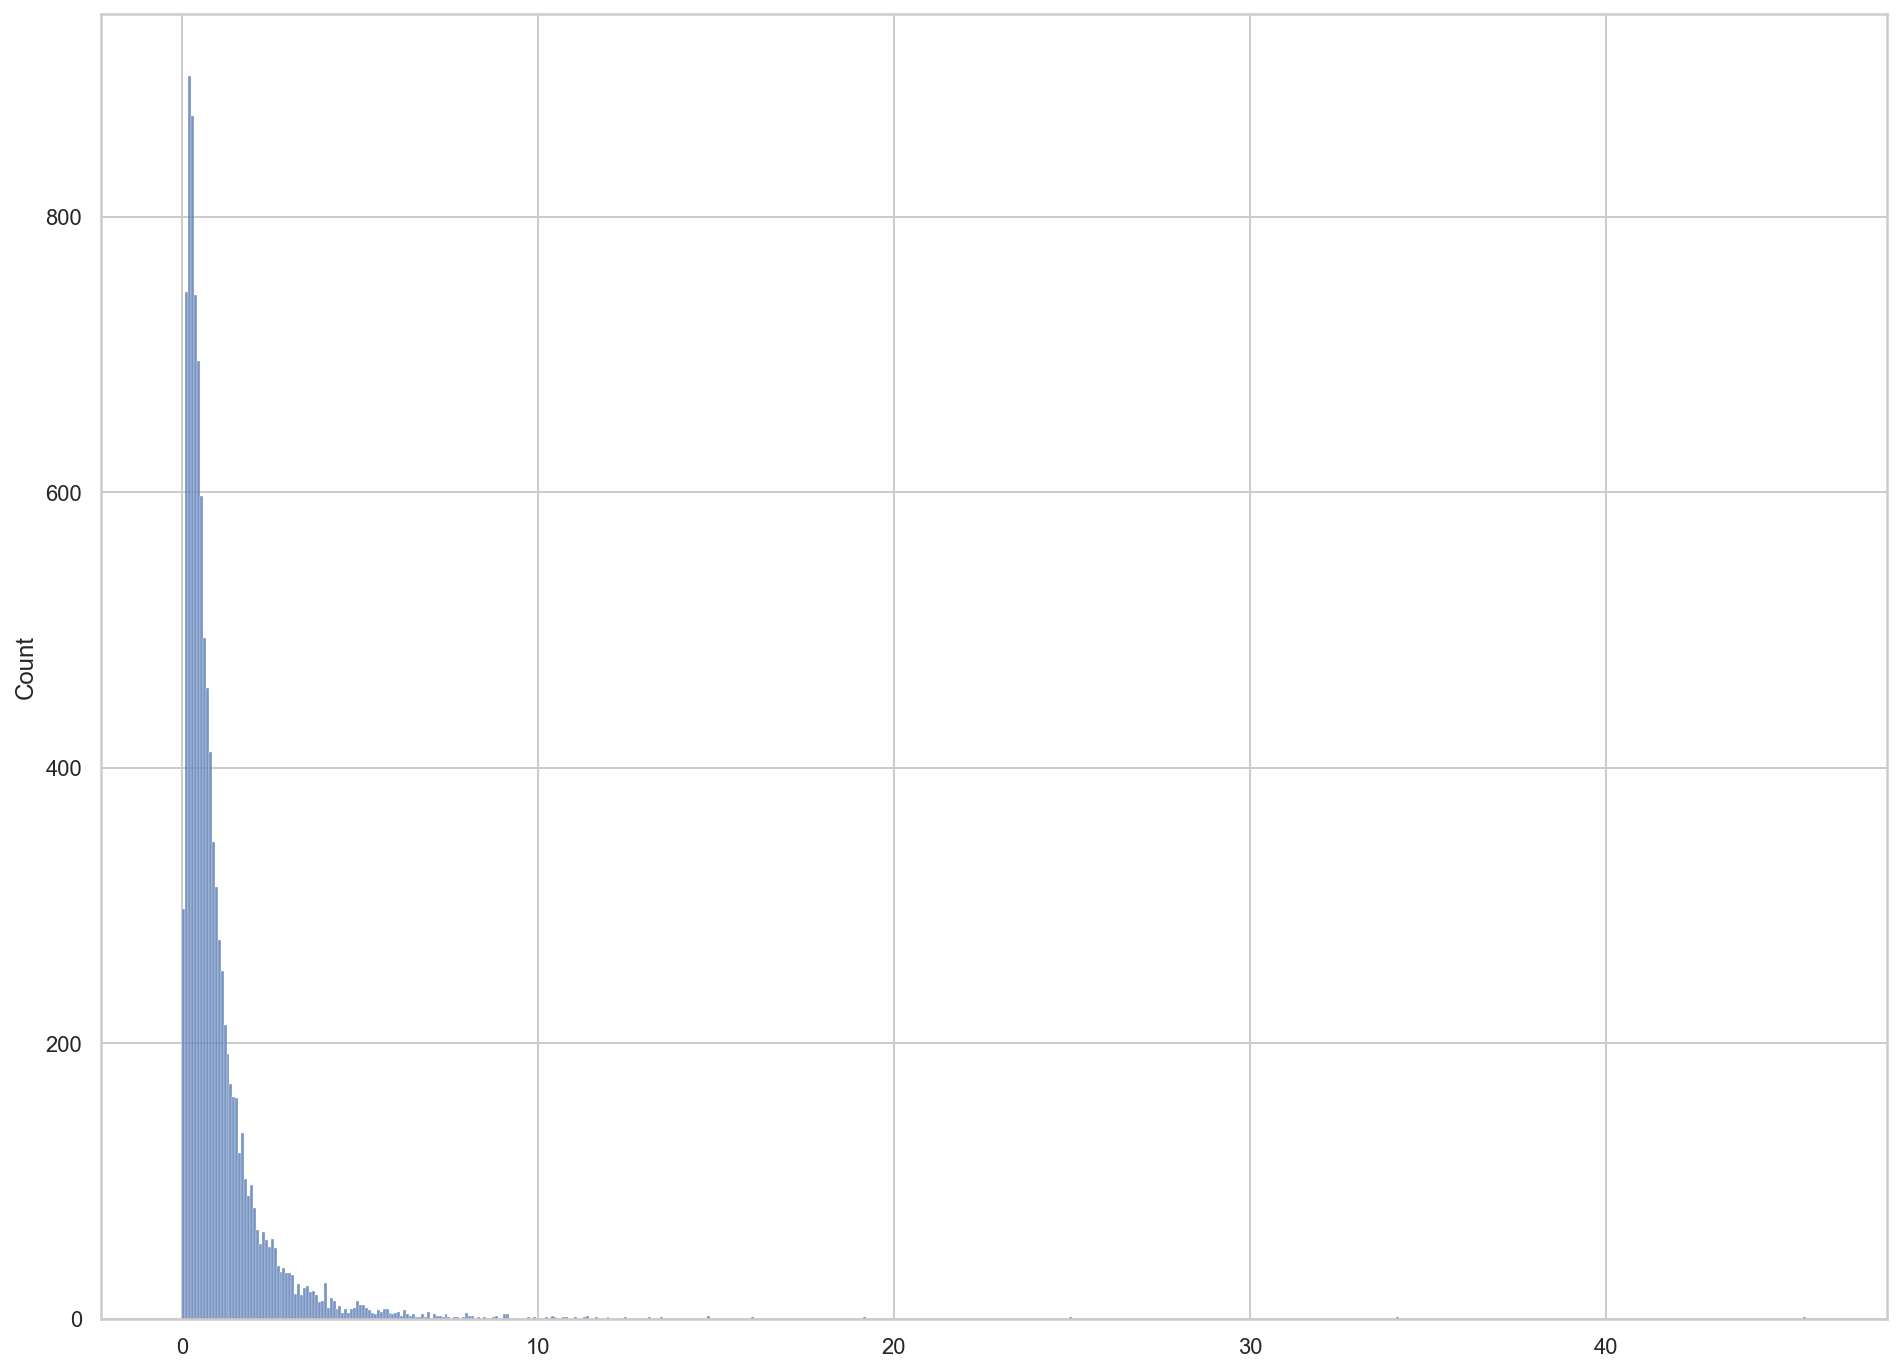

In [46]:
sns.histplot(dist.LogNormal(-0.5, 1.).sample((10_000,)))

In [ ]:
sns.histplot(dist.LogNormal(-0.5,10).sample((10_000,)))
plt.xlim(0, 5)